In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

from scipy import stats

In [2]:
def diagnostic_plots(x, y, y_pred):    
    
    plt.figure(figsize=(20,6))
    plt.tight_layout(pad=10.0)
    
    plt.subplot(1, 3, 1)
    plt.scatter(y_pred,y)
    plt.plot([0, 9e6], [0, 9e6], color='r', linestyle='-')
    plt.title('Actual vs. True Sale Price', size=18)
    plt.xlabel('Predicted Sale Price', size=16)
    plt.ylabel('Actual Sale Price', size=16)
    plt.xticks(size=12)
    plt.yticks(size=12)
    
    plt.subplot(1, 3, 2)
    res = y - y_pred
    plt.scatter(y_pred, res)
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.title('Residuals Plot', size=18)
    plt.xlabel('Predicted', size=16)
    plt.ylabel('Residual', size=16)
    plt.xticks(size=12)
    plt.yticks(size=12)
    
    plt.subplot(1, 3, 3)
    # specified theoretical distribution 
    stats.probplot(res, dist='norm', plot=plt)
    plt.title('Normal Q-Q plot', size=18)
    plt.xlabel('Theoretical Quantiles', size=16)
    plt.ylabel('Ordered Values', size=16)
    plt.xticks(size=12)
    plt.yticks(size=12)

In [3]:
df=pd.read_csv('redfin_data.csv')
df.shape

(1656, 23)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sold Price         1649 non-null   float64
 1   Beds               1649 non-null   float64
 2   Baths              1649 non-null   float64
 3   Floors             1632 non-null   float64
 4   Garage Spaces      1656 non-null   int64  
 5   Lot Size (sq ft)   1653 non-null   float64
 6   Home Size (sq ft)  1655 non-null   float64
 7   Year Built         1653 non-null   float64
 8   School Score Avg   1515 non-null   float64
 9   Walk Score         1538 non-null   float64
 10  Transit Score      1538 non-null   float64
 11  Bike Score         1538 non-null   float64
 12  Laundry            1656 non-null   bool   
 13  Heating            1656 non-null   bool   
 14  Air Conditioning   1656 non-null   bool   
 15  Pool               1656 non-null   bool   
 16  Address            1656 

In [5]:
## clean data

df.drop(columns=['Address', 'Sold Status', 'URL'], inplace = True)

df = df.dropna()
df.reset_index(drop=True, inplace=True)

df.columns= df.columns.str.lower()
df.rename(columns={'lot size (sq ft)': 'lot size', 'home size (sq ft)': 'home size'}, inplace=True)

df.drop(df.index[df['city'] == 'SAN JOSE'], inplace=True)

df.drop(df.index[df['city'] == 'EAST PALO ALTO'], inplace=True)

df.drop(df.index[df['county'] == 'SAN MATEO COUNTY'], inplace=True)

df.drop(columns=['county', 'zip code', 'property type'], inplace = True)

df['age of house'] = (df['year built'].max() + 1) - df['year built']

df.drop([126], inplace=True)
df.drop([951,952], inplace=True)
df.drop([1410], inplace=True)

df.drop(columns=['year built'], inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1293 entries, 0 to 1439
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sold price        1293 non-null   float64
 1   beds              1293 non-null   float64
 2   baths             1293 non-null   float64
 3   floors            1293 non-null   float64
 4   garage spaces     1293 non-null   int64  
 5   lot size          1293 non-null   float64
 6   home size         1293 non-null   float64
 7   school score avg  1293 non-null   float64
 8   walk score        1293 non-null   float64
 9   transit score     1293 non-null   float64
 10  bike score        1293 non-null   float64
 11  laundry           1293 non-null   bool   
 12  heating           1293 non-null   bool   
 13  air conditioning  1293 non-null   bool   
 14  pool              1293 non-null   bool   
 15  city              1293 non-null   object 
 16  age of house      1293 non-null   float64


In [6]:
df_temp = df.drop(columns=['walk score', 'transit score', 'bike score'])

In [7]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1293 entries, 0 to 1439
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sold price        1293 non-null   float64
 1   beds              1293 non-null   float64
 2   baths             1293 non-null   float64
 3   floors            1293 non-null   float64
 4   garage spaces     1293 non-null   int64  
 5   lot size          1293 non-null   float64
 6   home size         1293 non-null   float64
 7   school score avg  1293 non-null   float64
 8   laundry           1293 non-null   bool   
 9   heating           1293 non-null   bool   
 10  air conditioning  1293 non-null   bool   
 11  pool              1293 non-null   bool   
 12  city              1293 non-null   object 
 13  age of house      1293 non-null   float64
dtypes: bool(4), float64(8), int64(1), object(1)
memory usage: 116.2+ KB


In [8]:
bool_cols = {
                'laundry': int,
                'heating': int,
                'air conditioning': int,
                'pool': int
               }
  
df_temp = df_temp.astype(bool_cols)
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1293 entries, 0 to 1439
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sold price        1293 non-null   float64
 1   beds              1293 non-null   float64
 2   baths             1293 non-null   float64
 3   floors            1293 non-null   float64
 4   garage spaces     1293 non-null   int64  
 5   lot size          1293 non-null   float64
 6   home size         1293 non-null   float64
 7   school score avg  1293 non-null   float64
 8   laundry           1293 non-null   int64  
 9   heating           1293 non-null   int64  
 10  air conditioning  1293 non-null   int64  
 11  pool              1293 non-null   int64  
 12  city              1293 non-null   object 
 13  age of house      1293 non-null   float64
dtypes: float64(8), int64(5), object(1)
memory usage: 151.5+ KB


In [9]:
# bool_cols = {
#                 'beds': str,
#                 'baths': str,
#                 'floors': str,
#                 'garage spaces': str
#                }
  
# df_temp = df_temp.astype(bool_cols)
# df_temp.info()

In [10]:
# bed_count = df_temp['beds'].value_counts()

# bed_one = list(bed_count[bed_count == 2].index)
# df_temp['beds'] = df_temp['beds'].replace(bed_one, '1-2')

# bed_two = list(bed_count[bed_count == 69].index)
# df_temp['beds'] = df_temp['beds'].replace(bed_two, '1-2')

# bed_six = list(bed_count[bed_count == 24].index)
# df_temp['beds'] = df_temp['beds'].replace(bed_six, '6+')

# bed_seven = list(bed_count[bed_count == 4].index)
# df_temp['beds'] = df_temp['beds'].replace(bed_seven, '6+')

# df_temp['beds'].value_counts()

In [11]:
# bath_count = df_temp['baths'].value_counts()

# bath_6plus = list(bath_count[bath_count <= 6].index)
# df_temp['baths'] = df_temp['baths'].replace(bath_6plus, '6+')

# df_temp['baths'].value_counts()

In [12]:
# garage_count = df_temp['garage spaces'].value_counts()

# garage_3plus = list(garage_count[garage_count <= 29].index)
# df_temp['garage spaces'] = df_temp['garage spaces'].replace(garage_3plus, '3+')

# df_temp['garage spaces'].value_counts()

In [13]:
# df_dummies = pd.get_dummies(df_temp, columns=['beds', 'baths', 'floors', 'garage spaces', 'city'], drop_first=True)
# df_dummies.info()

df_dummies = pd.get_dummies(df_temp, columns=['city'], drop_first=True)
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1293 entries, 0 to 1439
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sold price          1293 non-null   float64
 1   beds                1293 non-null   float64
 2   baths               1293 non-null   float64
 3   floors              1293 non-null   float64
 4   garage spaces       1293 non-null   int64  
 5   lot size            1293 non-null   float64
 6   home size           1293 non-null   float64
 7   school score avg    1293 non-null   float64
 8   laundry             1293 non-null   int64  
 9   heating             1293 non-null   int64  
 10  air conditioning    1293 non-null   int64  
 11  pool                1293 non-null   int64  
 12  age of house        1293 non-null   float64
 13  city_LOS ALTOS      1293 non-null   uint8  
 14  city_MOUNTAIN VIEW  1293 non-null   uint8  
 15  city_PALO ALTO      1293 non-null   uint8  
 16  city_S

In [14]:
df_dummies.corr()

,sold price,beds,baths,floors,garage spaces,lot size,home size,school score avg,laundry,heating,air conditioning,pool,age of house,city_LOS ALTOS,city_MOUNTAIN VIEW,city_PALO ALTO,city_SANTA CLARA,city_SUNNYVALE
sold price,1.000000,0.530492,0.608565,0.295525,0.070803,0.495573,0.776482,0.637453,0.030058,-0.052177,0.033257,0.095984,-0.261373,0.421027,-0.016922,0.433192,-0.448300,-0.245311
beds,0.530492,1.000000,0.684862,0.419186,0.158194,0.285794,0.729702,0.245496,0.040732,0.049096,0.156342,0.072869,-0.313947,0.168198,-0.062381,0.117253,-0.138993,-0.081228
baths,0.608565,0.684862,1.000000,0.517454,0.109036,0.229351,0.825005,0.247759,0.028231,-0.005671,0.202059,0.062296,-0.467915,0.213179,-0.046697,0.167918,-0.155310,-0.141800
floors,0.295525,0.419186,0.517454,1.000000,0.100936,-0.051633,0.535945,0.141769,0.043062,0.039051,0.173748,0.047888,-0.488101,0.002703,0.037985,0.106708,-0.100704,-0.095439
garage spaces,0.070803,0.158194,0.109036,0.100936,1.000000,0.195348,0.152825,0.064918,0.142090,0.737359,0.440811,0.064374,-0.157010,0.009250,-0.017153,-0.123470,0.031963,0.077991
lot size,0.495573,0.285794,0.229351,-0.051633,0.195348,1.000000,0.390393,0.328632,-0.014230,0.125264,0.065769,0.055809,0.041140,0.441816,-0.101877,0.048737,-0.167372,-0.140826
home size,0.776482,0.729702,0.825005,0.535945,0.152825,0.390393,1.000000,0.353453,0.031583,0.004332,0.190462,0.097545,-0.437366,0.293041,-0.042825,0.196868,-0.228583,-0.158483
school score avg,0.637453,0.245496,0.247759,0.141769,0.064918,0.328632,0.353453,1.000000,-0.050016,-0.037007,-0.052159,0.142711,-0.133168,0.309333,0.035047,0.349123,-0.517175,-0.264892
laundry,0.030058,0.040732,0.028231,0.043062,0.142090,-0.014230,0.031583,-0.050016,1.000000,0.211829,0.093681,0.061526,-0.015086,-0.016133,0.121867,0.085213,0.051701,-0.106014
heating,-0.052177,0.049096,-0.005671,0.039051,0.737359,0.125264,0.004332,-0.037007,0.211829,1.000000,0.508160,-0.002280,-0.035175,-0.037343,-0.021248,-0.048832,0.042022,0.045497


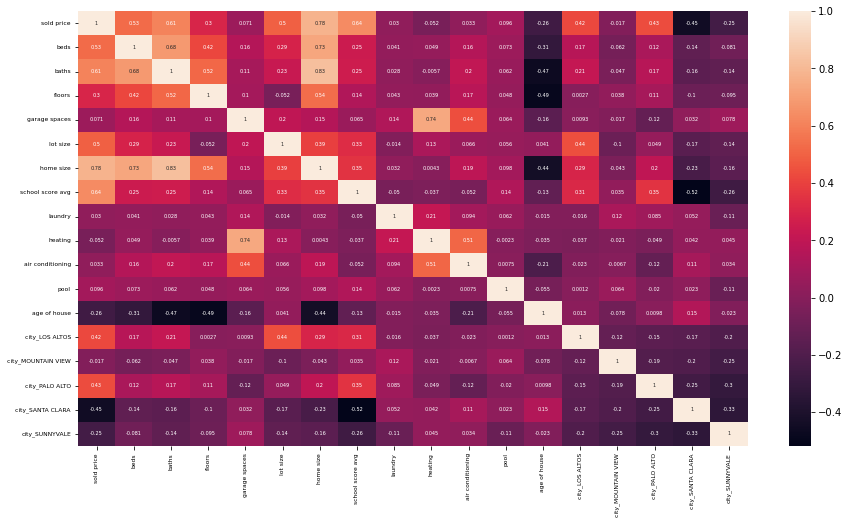

In [15]:
plt.figure(figsize=(15,8))

ax = sns.heatmap(df_dummies.corr(), annot=True, annot_kws={'size':5})
ax.set_xticklabels(ax.get_xticklabels(), size=6)
ax.set_yticklabels(ax.get_yticklabels(), size=6);

In [16]:
## BEGIN RIDGE REGRESSION SCORING

In [17]:
x = df_dummies.drop(columns=['sold price'])
y = df_dummies['sold price']

In [18]:
x, x_test, y, y_test = train_test_split(x, y,
                                        test_size = 0.2,
                                        random_state = 42)

x_tr, x_val, y_tr, y_val = train_test_split(x, y,
                                            test_size = 0.25,
                                            random_state = 42)



In [19]:
## instantiate and fit StandardScaler()
std = StandardScaler()
std.fit(x_tr.values)

## apply the scaler to the train set
x_tr_std = std.transform(x_tr.values)

## apply the scaler to the validation set
x_val_std = std.transform(x_val.values)

## find optimal penalty term thru CV
alphas = 10**np.linspace(-2,2,200)

lr_ridge = RidgeCV(alphas = alphas, cv=5)
lr_ridge.fit(x_tr_std, y_tr)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [20]:
## r2 score of train set
r2_train = lr_ridge.score(x_tr_std, y_tr)

## adj r2 score of train
adj_r2_train = 1-(1-r2_train)*(x_tr_std.shape[0]-1)/(x_tr_std.shape[0]-x_tr_std.shape[1]-1)

## r2 score of validation set
r2_val = lr_ridge.score(x_val_std,y_val)

## adj r2 score of validation set
adj_r2_val = 1-(1-r2_val)*(x_val_std.shape[0]-1)/(x_val_std.shape[0]-x_val_std.shape[1]-1)

print('\nr2 (Train Data): ', r2_train)
print('r2 (Validation Data): ', r2_val)

print('\nAdjusted r2 (Train Data): ', adj_r2_train)
print('Adjusted r2 (Validation Data): ', adj_r2_val)


r2 (Train Data):  0.857995359060822
r2 (Validation Data):  0.8144680824623027

Adjusted r2 (Train Data):  0.8548063512722275
Adjusted r2 (Validation Data):  0.801380768777071


In [21]:
## mae train
mae_train = round(mean_absolute_error(y_tr, lr_ridge.predict(x_tr_std)),2)

## mae validation
mae_val = round(mean_absolute_error(y_val, lr_ridge.predict(x_val_std)),2)

## rmse train
rmse_train = round(mean_squared_error(y_tr, lr_ridge.predict(x_tr_std), squared=False),2)

## rmse validation
rmse_val = round(mean_squared_error(y_val, lr_ridge.predict(x_val_std), squared=False),2)

print('\nMean Absolute Error (Train Data): ', mae_train)
print('Mean Absolute Error (Validation Data): ', mae_val)

print('\nRoot Mean Squared Error (Train Data): ', rmse_train)
print('Root Mean Squared Error (Validation Data): ', rmse_val)


Mean Absolute Error (Train Data):  343480.77
Mean Absolute Error (Validation Data):  370631.69

Root Mean Squared Error (Train Data):  471794.74
Root Mean Squared Error (Validation Data):  500365.04


In [22]:
lr_predict_train = lr_ridge.predict(x_tr_std)
lr_predict_val = lr_ridge.predict(x_val_std)

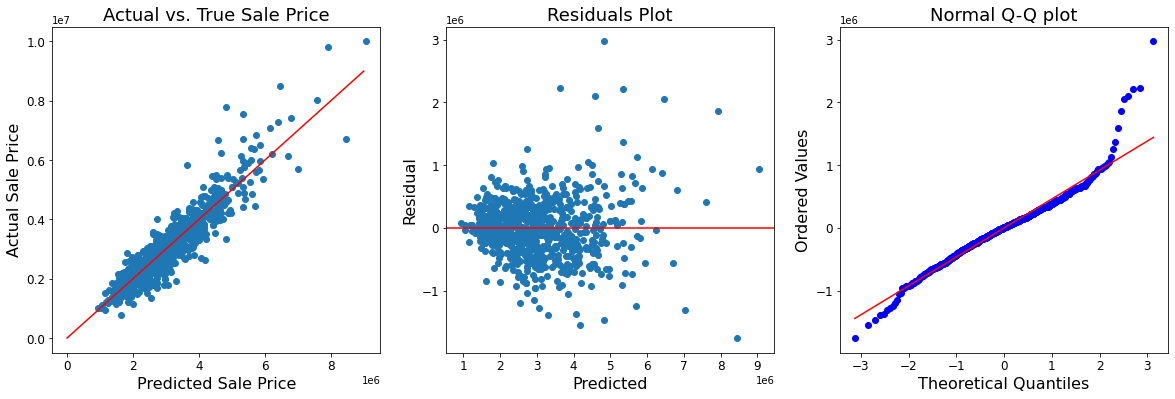

In [23]:
## diagnostic plots train
diagnostic_plots(x_tr_std, y_tr, lr_predict_train)

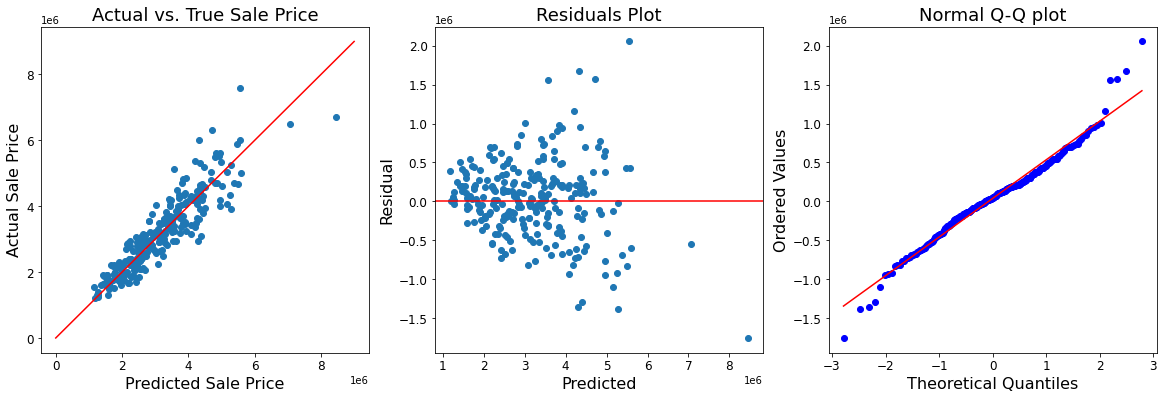

In [24]:
## diagnostic plots validation
diagnostic_plots(x_val_std, y_val, lr_predict_val)

In [25]:
# list(zip(x_tr.columns, lr_ridge.coef_))